In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import pickle
import numpy as np
import os

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Pride and Prejudice.txt to Pride and Prejudice.txt


In [3]:
file = open("Pride and Prejudice.txt", "r", encoding = "utf8")

# Store file in list
lines = []
for i in file:
  lines.append(i)

#converting list to string
data = ""
for i in lines:
  data = ''.join(lines)

#replace unnecessary stuff with space
data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '').replace('“','').replace('”','')

#remove unnecessary spaces 
data = data.split()
data = ' '.join(data)
data[:500]


'The Project Gutenberg eBook of Pride and Prejudice, by Jane AustenThis eBook is for the use of anyone anywhere in the United States andmost other parts of the world at no cost and with almost no restrictionswhatsoever. You may copy it, give it away or re-use it under the termsof the Project Gutenberg License included with this eBook or online atwww.gutenberg.org. If you are not located in the United States, youwill have to check the laws of the country where you are located beforeusing this eBoo'

In [4]:
len(data)

698067

In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])

# saving the tokenizer for predict function
pickle.dump(tokenizer, open('token.pkl', 'wb'))

sequence_data = tokenizer.texts_to_sequences([data])[0]
sequence_data[:15]

[1, 223, 186, 912, 3, 328, 4, 1351, 30, 72, 4174, 912, 23, 21, 1]

In [6]:
len(sequence_data)

125076

In [7]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

7200


In [8]:
sequences = []

for i in range(3, len(sequence_data)):
    words = sequence_data[i-3:i+1]
    sequences.append(words)
    
print("The Length of sequences are: ", len(sequences))
sequences = np.array(sequences)
sequences[:10]

The Length of sequences are:  125073


array([[   1,  223,  186,  912],
       [ 223,  186,  912,    3],
       [ 186,  912,    3,  328],
       [ 912,    3,  328,    4],
       [   3,  328,    4, 1351],
       [ 328,    4, 1351,   30],
       [   4, 1351,   30,   72],
       [1351,   30,   72, 4174],
       [  30,   72, 4174,  912],
       [  72, 4174,  912,   23]])

In [9]:
X = []
y = []

for i in sequences:
    X.append(i[0:3])
    y.append(i[3])
    
X = np.array(X)
y = np.array(y)

In [10]:
print("Data: ", X[:10])
print("Response: ", y[:10])

Data:  [[   1  223  186]
 [ 223  186  912]
 [ 186  912    3]
 [ 912    3  328]
 [   3  328    4]
 [ 328    4 1351]
 [   4 1351   30]
 [1351   30   72]
 [  30   72 4174]
 [  72 4174  912]]
Response:  [ 912    3  328    4 1351   30   72 4174  912   23]


In [11]:
y = to_categorical(y, num_classes=vocab_size)
y[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [12]:
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=3))
model.add(LSTM(1000, return_sequences=True))
model.add(LSTM(1000))
model.add(Dense(1000, activation="relu"))
model.add(Dense(vocab_size, activation="softmax"))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 10)             72000     
                                                                 
 lstm (LSTM)                 (None, 3, 1000)           4044000   
                                                                 
 lstm_1 (LSTM)               (None, 1000)              8004000   
                                                                 
 dense (Dense)               (None, 1000)              1001000   
                                                                 
 dense_1 (Dense)             (None, 7200)              7207200   
                                                                 
Total params: 20,328,200
Trainable params: 20,328,200
Non-trainable params: 0
_________________________________________________________________


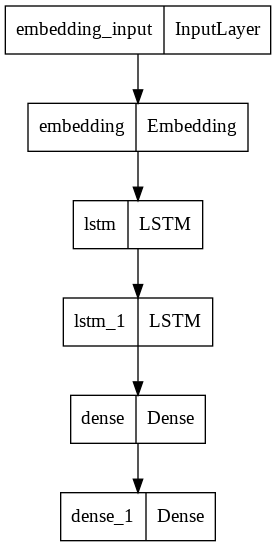

In [14]:
from tensorflow import keras
from keras.utils.vis_utils import plot_model

keras.utils.plot_model(model, to_file='plot.png', show_layer_names=True)

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("next_words.h5", monitor='loss', verbose=1, save_best_only=True)
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001))
model.fit(X, y, epochs=70, batch_size=64, callbacks=[checkpoint])

Epoch 1/70
1955/1955 [==============================] - ETA: 0s - loss: 6.2304
Epoch 00001: loss improved from inf to 6.23035, saving model to next_words.h5
1955/1955 [==============================] - 72s 32ms/step - loss: 6.2304
Epoch 2/70
1955/1955 [==============================] - ETA: 0s - loss: 5.6154
Epoch 00002: loss improved from 6.23035 to 5.61541, saving model to next_words.h5
1955/1955 [==============================] - 64s 32ms/step - loss: 5.6154
Epoch 3/70
1954/1955 [============================>.] - ETA: 0s - loss: 5.2893
Epoch 00003: loss improved from 5.61541 to 5.28957, saving model to next_words.h5
1955/1955 [==============================] - 63s 32ms/step - loss: 5.2896
Epoch 4/70
1955/1955 [==============================] - ETA: 0s - loss: 5.0468
Epoch 00004: loss improved from 5.28957 to 5.04682, saving model to next_words.h5
1955/1955 [==============================] - 63s 32ms/step - loss: 5.0468
Epoch 5/70
1955/1955 [==============================] - ETA: 0s 

In [16]:
from tensorflow.keras.models import load_model
import numpy as np
import pickle

# Load the model and tokenizer
model = load_model('next_words.h5')
tokenizer = pickle.load(open('token.pkl', 'rb'))

def Predict_Next_Words(model, tokenizer, text):

  sequence = tokenizer.texts_to_sequences([text])
  sequence = np.array(sequence)
  preds = np.argmax(model.predict(sequence))
  predicted_word = ""
  
  for key, value in tokenizer.word_index.items():
      if value == preds:
          predicted_word = key
          break
  
  print(predicted_word)
  return predicted_word

In [ ]:
while(True):
  text = input("Enter your line: ")
  
  if text == "0":
      print("Execution completed.....")
      break
  
  else:
      try:
          text = text.split(" ")
          text = text[-3:]
          print(text)
        
          Predict_Next_Words(model, tokenizer, text)
          
      except Exception as e:
        print("Error occurred: ",e)
        continue

Enter your line: hi
['hi']
Error occurred:  in user code:

    File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1572, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.7/dist-packages/keras/engine/input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {inpu